In [14]:
import pandas as pd
import numpy as np
import utils as u
import matplotlib.pyplot as plt
import scipy.stats as stat
import empiricaldist as ed

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

In [4]:
# download('https://github.com/allisonhorst/palmerpenguins/blob/main/inst/extdata/penguins_raw.csv')

Downloaded penguins_raw.csv


In [6]:
df = pd.read_csv('penguins_raw.csv')
print(df.shape)
df.head()

(344, 17)


,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


In [8]:
df['Species'].unique()

array(['Adelie Penguin (Pygoscelis adeliae)',
       'Gentoo penguin (Pygoscelis papua)',
       'Chinstrap penguin (Pygoscelis antarctica)'], dtype=object)

Three species of penguins are represented in the dataset: Adélie, Chinstrap and Gentoo.

The measurements we’ll use are:

Body Mass in grams (g).

Flipper Length in millimeters (mm).

Culmen Length in millimeters.

Culmen Depth in millimeters.

If you are not familiar with the word “culmen”, it refers to the top margin of the beak.

These measurements will be most useful for classification if there are substantial differences between species and small variation within species. To see whether that is true, and to what degree, I’ll plot cumulative distribution functions (CDFs) of each measurement for each species.

The following function takes the DataFrame and a column name. It returns a dictionary that maps from each species name to a Cdf of the values in the column named colname.

In [15]:
def make_cdf_map(df, colname, by='Species2'):
    """Make a CDF for each species."""
    cdf_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        cdf_map[species] = ed.Cdf.from_seq(group, name=species)
    return cdf_map

def plot_cdfs(df, colname, by='Species2'):
    """Make a CDF for each species.
    
    df: DataFrame
    colname: string column name
    by: string column name

    returns: dictionary from species name to Cdf
    """
    cdf_map = make_cdf_map(df, colname, by)
    
    for species, cdf in cdf_map.items():
        cdf.plot(label=species, marker='')
    
    u.decorate(xlabel=colname,
             ylabel='CDF')

In [12]:
df['Species2'] = df['Species'].apply(lambda x: x.lower().split(' penguin')[0])
df['Species2'].unique()

array(['adelie', 'gentoo', 'chinstrap'], dtype=object)

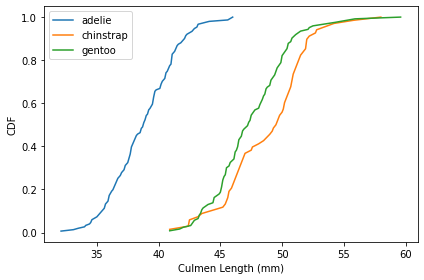

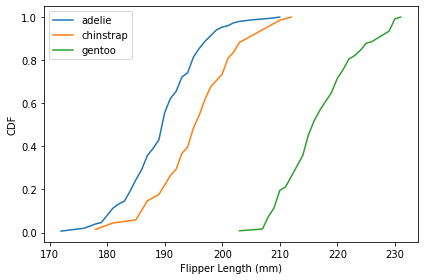

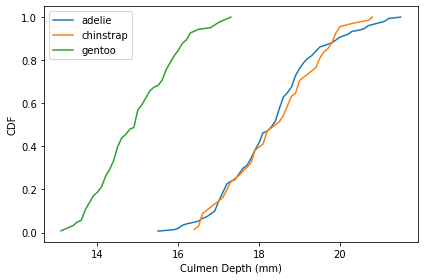

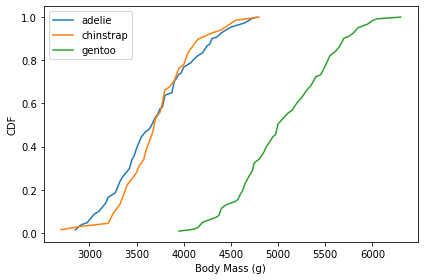

In [19]:
cols = [
    'Culmen Length (mm)',
    'Flipper Length (mm)',
    'Culmen Depth (mm)',
    'Body Mass (g)'
]
for colname in cols:
    plot_cdfs(df, colname)
    plt.show()
    plt.close()

It looks like we can use culmen length to identify Adélie penguins, but the distributions for the other two species almost entirely overlap.

Using flipper length, we can distinguish Gentoo penguins from the other two species. So with just these two features, it seems like we should be able to classify penguins with some accuracy.

All of these CDFs show the sigmoid shape characteristic of the normal distribution; I will take advantage of that observation in the next section.

Culmen depth and body mass distinguish Gentoo penguins from the other two species, but these features might not add a lot of additional information, beyond what we get from flipper length and culmen length

## Normal models

Let’s use these features to classify penguins. We’ll proceed in the usual Bayesian way:

 1) Define a prior distribution with the three possible species and a prior probability for each,
 2) Compute the likelihood of the data for each hypothetical species, and then
 3) Compute the posterior probability of each hypothesis.

To compute the likelihood of the data under each hypothesis, I’ll use the data to estimate the parameters of a normal distribution for each species.

In [20]:
def make_norm_map(df, colname, by='Species2'):
    """Make a map from species to norm object."""
    norm_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        mean = group.mean()
        std = group.std()
        norm_map[species] = stat.norm(mean, std)
    return norm_map

Now suppose we measure a penguin and find that its flipper is 193 mm. What is the probability of that measurement under each hypothesis?

In [21]:
flipper_map = make_norm_map(df, 'Flipper Length (mm)')
data = 193

In [24]:
[(class_, hypo.pdf(data)) for class_, hypo in flipper_map.items()]

[('adelie', 0.054732511875530694),
 ('chinstrap', 0.051721356158881626),
 ('gentoo', 5.866045366199098e-05)]

In [25]:
prior = ed.Pmf(1, flipper_map.keys())
prior.normalize()
prior

,probs
adelie,0.333333
chinstrap,0.333333
gentoo,0.333333


In [26]:
posterior = prior * [(flipper_map[hypo].pdf(data)) for hypo in flipper_map]
posterior.normalize()
posterior

,probs
adelie,0.513860
chinstrap,0.485589
gentoo,0.000551


A penguin with a 193 mm flipper is unlikely to be a Gentoo, but might be either an Adélie or Chinstrap (assuming that the three species were equally likely before the measurement).

In [27]:
def update_penguin(prior, data, norm_map):
    """Update hypothetical species."""
    hypos = prior.qs
    likelihood = [norm_map[hypo].pdf(data) for hypo in hypos]
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

In [28]:
update_penguin(prior, 193, flipper_map)

,probs
adelie,0.513860
chinstrap,0.485589
gentoo,0.000551


As we saw in the CDFs, flipper length does not distinguish strongly between Adélie and Chinstrap penguins.

But culmen length can make this distinction, so let’s use it to do a second round of classification. First we estimate distributions of culmen length for each species like this:

In [29]:
culmen_map = make_norm_map(df, 'Culmen Length (mm)')
posterior2 = update_penguin(prior, 48, culmen_map)
posterior2

,probs
adelie,0.001557
chinstrap,0.474658
gentoo,0.523785


A penguin with culmen length 48 mm is about equally likely to be a Chinstrap or Gentoo.

Using one feature at a time, we can often rule out one species or another, but we generally can’t identify species with confidence. We can do better using multiple features

## Naive Bayesian CLassification

To make it easier to do multiple updates, I’ll use the following function, which takes a prior Pmf, a sequence of measurements and a corresponding sequence of dictionaries containing estimated distributions.

In [31]:
def update_naive(prior, data_seq, norm_maps):
    """Naive Bayesian classifier
    
    prior: Pmf
    data_seq: sequence of measurements
    norm_maps: sequence of maps from species to distribution
    
    returns: Pmf representing the posterior distribution
    """
    posterior = prior.copy()
    for data, norm_map in zip(data_seq, norm_maps):
        posterior = update_penguin(posterior, data, norm_map)
    return posterior

In [32]:
colnames = ['Flipper Length (mm)', 'Culmen Length (mm)']
norm_maps = [flipper_map, culmen_map]

data_seq = 193, 48
posterior = update_naive(prior, data_seq, norm_maps)
posterior

,probs
adelie,0.003455
chinstrap,0.995299
gentoo,0.001246


In [33]:
posterior.max_prob()

'chinstrap'

In [34]:
# make classification on dataset 
"""
You could split dataset, take central tendencies from train and then after each test example update these means and stds with
reinforcement learning like mean update with learning rate. 
new_mean = old_mean + lr*(value - old_mean). LR can be replaced with 1/n_samples
"""

df['Classification'] = np.nan

for i, row in df.iterrows():
    data_seq = row[colnames]
    posterior = update_naive(prior, data_seq, norm_maps)
    df.loc[i, 'Classification'] = posterior.max_prob()

same = df['Species2'] == df['Classification']

same.sum() / df['Classification'].notna().sum()

0.9473684210526315

The classifier we used in this section is called “naive” because it ignores correlations between the features. To see why that matters, I’ll make a less naive classifier: one that takes into account the joint distribution of the features.

Also we did not split dataset which gives biased result!

## Joint Distributions



In [76]:
def scatterplot(df, var1, var2, by='Species2'):
    """Make a scatter plot."""
    grouped = df.groupby(by)
    for species, group in grouped:
        plt.scatter(group[var1], group[var2],
                 label=species, lw=0, alpha=0.3)
    
    u.decorate(xlabel=var1, ylabel=var2)

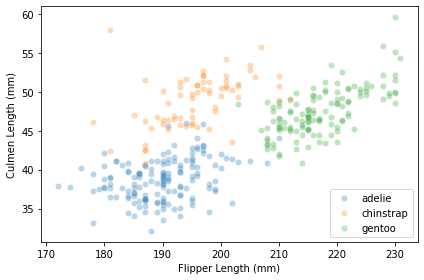

In [49]:
var1 = 'Flipper Length (mm)'
var2 = 'Culmen Length (mm)'
scatterplot(df, var1, var2)

Within each species, the joint distribution of these measurements forms an oval shape, at least roughly. The orientation of the ovals is along a diagonal, which indicates that there is a correlation between culmen length and flipper length.
If we ignore these correlations, we are assuming that the features are independent. In next plot we will see how that looks like

In [50]:
def make_pmf_norm(dist, sigmas=3, n=101):
    """Make a Pmf approximation to a normal distribution."""
    mean, std = dist.mean(), dist.std()
    low = mean - sigmas * std
    high = mean + sigmas * std
    qs = np.linspace(low, high, n)
    ps = dist.pdf(qs)
    pmf = ed.Pmf(ps, qs)
    pmf.normalize()
    return pmf

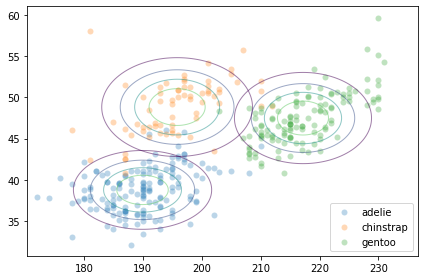

In [51]:
joint_map = {}
hypos = df['Species2'].unique()
for species in hypos:
    pmf1 = make_pmf_norm(flipper_map[species])
    pmf2 = make_pmf_norm(culmen_map[species])
    joint_map[species] = u.make_joint(pmf1, pmf2)

scatterplot(df, var1, var2)
for species in hypos:
    u.plot_contour(joint_map[species], alpha=0.5)

The contours of a joint normal distribution form ellipses. In this example, because the features are uncorrelated, the ellipses are aligned with the axes. But they are not well aligned with the data.

We can make a better model of the data, and use it to compute better likelihoods, with a multivariate normal distribution.

## Multivariate Normal Distribution

As we have seen, a univariate normal distribution is characterized by its mean and standard deviation.

A multivariate normal distribution is characterized by the means of the features and the **covariance matrix**, which contains **variances**, which quantify the spread of the features, and the **covariances**, which quantify **the relationships among them.**

We can use the data to estimate the means and covariance matrix for the population of penguins. First I’ll select the columns we want.

In [52]:
features = df[[var1, var2]]
mean = features.mean()

# The elements on the diagonal are the variances; the elements off the diagonal are covariances. 
# By themselves, variances and covariances are hard to interpret. We can use them to compute standard deviations 
# and correlation coefficients, which are easier to interpret.
cov = features.cov()
cov

,Flipper Length (mm),Culmen Length (mm)
Flipper Length (mm),197.731792,50.375765
Culmen Length (mm),50.375765,29.807054


In [75]:
def make_multinorm_map(df, colnames, by='Species2'):
    """Make a map from each species to a multivariate normal."""
    multinorm_map = {}
    grouped = df.groupby(by)
    for species, group in grouped:
        features = group[colnames]
        mean = features.mean()
        cov = features.cov()
        multinorm_map[species] = stat.multivariate_normal(mean, cov)
    return multinorm_map

In [54]:
multinorm_map = make_multinorm_map(df, [var1, var2])
multinorm_map

{'adelie': <scipy.stats._multivariate.multivariate_normal_frozen at 0x243c4b5d5e0>,
 'chinstrap': <scipy.stats._multivariate.multivariate_normal_frozen at 0x243c4a96eb0>,
 'gentoo': <scipy.stats._multivariate.multivariate_normal_frozen at 0x243c4979f10>}

### Visualizing a Multivariate Normal Distribution

This section uses some NumPy magic to generate contour plots for multivariate normal distributions. If that’s interesting for you, great! Otherwise, feel free to skip to the results. In the next section we’ll do the actual classification, which turns out to be easier than the visualization.

I’ll start by making a contour map for the distribution of features among Adélie penguins.
Here are the univariate distributions for the two features we’ll use and the multivariate distribution we just computed.

In [56]:
def make_joint(norm1, norm2, multinorm):
    """Make a joint distribution.
    
    norm1: `norm` object representing the distribution of the first feature
    norm2: `norm` object representing the distribution of the second feature
    multinorm: `multivariate_normal` object representing the joint distribution
    """
    # discrete Pmf approximation for each of the univariate distributions
    pmf1 = make_pmf_norm(norm1)
    pmf2 = make_pmf_norm(norm2)
    #  mesh grid that contains all pairs of values
    X, Y = np.meshgrid(pmf1.qs, pmf2.qs) #The mesh is represented by two arrays: the first contains the quantities from pmf1 along the x axis; the second contains the quantities from pmf2 along the y axis.
    # In order to evaluate the multivariate distribution for each pair of values, we have to “stack” the arrays.
    pos = np.dstack((X, Y)) 
    # The result is a 3-D array that you can think of as a 2-D array of pairs. When we pass this array to multinorm.pdf, it evaluates the probability density function of the distribution for each pair of values.
    densities = multinorm.pdf(pos)
    joint = pd.DataFrame(densities, columns=pmf1.qs, index=pmf2.qs)
    return joint

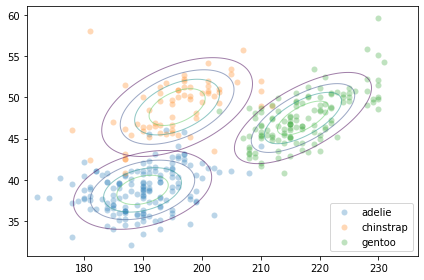

In [57]:
scatterplot(df, var1, var2)

for species in hypos:
    norm1 = flipper_map[species]
    norm2 = culmen_map[species]
    multinorm = multinorm_map[species]
    joint = make_joint(norm1, norm2, multinorm)
    u.plot_contour(joint, alpha=0.5)

Because the multivariate normal distribution takes into account the correlations between features, it is a better model for the data. And there is less overlap in the contours of the three distributions, which suggests that they should yield better classifications.

## Less Naive Classifier

Last time we used this function, the values in norm_map were norm objects, but it also works if they are multivariate_normal objects.

In [58]:
data = 193, 48
update_penguin(prior, data, multinorm_map)

,probs
adelie,0.002740
chinstrap,0.997257
gentoo,0.000003


In [60]:
df['Classification'] = np.nan

for i, row in df.iterrows():
    data = row[colnames]
    posterior = update_penguin(prior, data, multinorm_map)
    df.loc[i, 'Classification'] = posterior.idxmax()

same = df['Classification'] == df['Species2']
print('Acc:', same.sum()/df['Classification'].notna().sum())

Acc: 0.9532163742690059


It turns out to be only a little better: the accuracy is 95.3%, compared to 94.7% for the naive Bayesian classifier.

In [61]:
df[df['Classification'].isna()].head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments,Species2,Classification
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.,adelie,NaN
271,PAL0910,120,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A2,No,2009-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled. Nest never observed with fu...,gentoo,NaN


## Exercises

In my example I used culmen length and flipper length because they seemed to provide the most power to distinguish the three species. But maybe we can do better by using more features.

Make a naive Bayesian classifier that uses all four measurements in the dataset: culmen length and depth, flipper length, and body mass. Is it more accurate than the model with two features?

In [70]:
columns = [
    'Culmen Length (mm)',
    'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)'
]
df.dropna(inplace=True)
cov = df[columns].cov()

multi_map = make_multinorm_map(
    df, columns
)

In [71]:
df['Classification'] = None
for i, row in df.iterrows():
    data = row[columns]
    posterior = update_penguin(
        prior,
        data,
        multi_map
    )
    df.loc[i, 'Classification'] = posterior.max_prob()

In [72]:
same = df['Classification'] == df['Species2']
same.sum() / len(df)

0.9705882352941176

One of the reasons the penguin dataset was collected was to quantify sexual dimorphism in different penguin species, that is, physical differences between male and female penguins. One way to quantify dimorphism is to use measurements to classify penguins by sex. If a species is more dimorphic, we expect to be able to classify them more accurately.

As an exercise, pick a species and use a Bayesian classifier (naive or not) to classify the penguins by sex. Which features are most useful? What accuracy can you achieve?

In [79]:
df['Species2'].value_counts()

chinstrap    14
adelie       13
gentoo        7
Name: Species2, dtype: int64

In [80]:
dff = df[df['Species2']=='chinstrap']

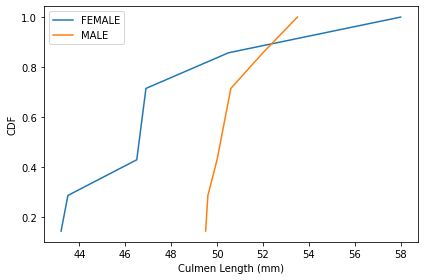

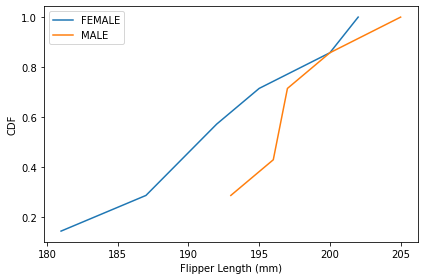

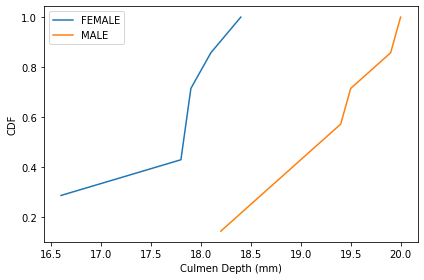

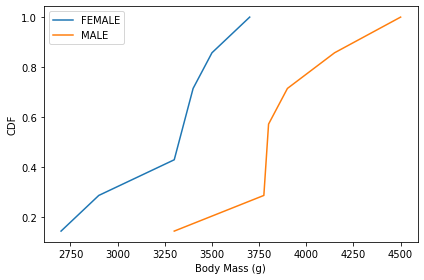

In [81]:
cols = [
    'Culmen Length (mm)',
    'Flipper Length (mm)',
    'Culmen Depth (mm)',
    'Body Mass (g)'
]
for colname in cols:
    plot_cdfs(dff, colname, by='Sex')
    plt.show()
    plt.close()

In [83]:
make_norm_map(dff, var1, 'Sex')

{'FEMALE': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x243c49712e0>,
 'MALE': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x243c4971040>}

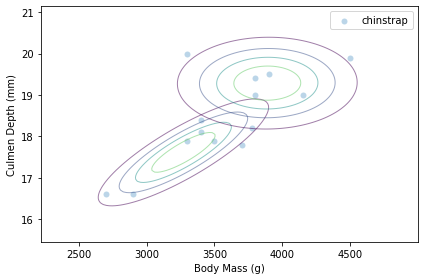

In [85]:
var1, var2 = 'Body Mass (g)', 'Culmen Depth (mm)'

multinorm_map = make_multinorm_map(dff, [var1, var2], 'Sex')
scatterplot(dff, var1, var2)
for sex in ['FEMALE', 'MALE']:
    norm1 = make_norm_map(dff, var1, 'Sex')[sex]
    norm2 = make_norm_map(dff, var2, 'Sex')[sex]
    multinorm = multinorm_map[sex]
    joint = make_joint(norm1, norm2, multinorm)
    u.plot_contour(joint, alpha=0.5)
    u.decorate(
        xlabel=var1, ylabel=var2
    )

In [87]:
dff[cols].cov()

,Culmen Length (mm),Flipper Length (mm),Culmen Depth (mm),Body Mass (g)
Culmen Length (mm),15.119560,-3.392308,2.010769,1139.945055
Flipper Length (mm),-3.392308,38.000000,3.807692,1142.307692
Culmen Depth (mm),2.010769,3.807692,1.167308,377.596154
Body Mass (g),1139.945055,1142.307692,377.596154,222132.554945


In [91]:
multi_var = make_multinorm_map(
    dff,
    cols,
    'Sex'
)
prior2 = ed.Pmf.from_seq(['FEMALE', 'MALE'])
prior2

,probs
FEMALE,0.5
MALE,0.5


In [96]:
dff['Classification'] = None
for i, row in dff.iterrows():
    data = row[cols]
    posterior = update_penguin(
        prior2,
        data,
        multi_var
    )
    dff.loc[i, 'Classification'] = posterior.max_prob()

same = dff['Classification'] == dff['Sex']
same.sum() / len(dff)

C:\Users\MAREK~1.KAN\AppData\Local\Temp/ipykernel_3580/1634184364.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Classification'] = None


1.0

In [97]:
posterior

,probs
FEMALE,0.022098
MALE,0.977902


In [99]:
dff[['Classification', 'Sex']]

,Classification,Sex
276,FEMALE,FEMALE
277,MALE,MALE
292,MALE,MALE
293,FEMALE,FEMALE
298,FEMALE,FEMALE
299,MALE,MALE
300,FEMALE,FEMALE
301,MALE,MALE
302,FEMALE,FEMALE
303,MALE,MALE


In [134]:
def classify_sex_by_species(species,columns):
    hypos = ['FEMALE', 'MALE']
    tmp = df[df['Species2']==species].copy()
    try:
        norm = make_multinorm_map(
            tmp, columns, 'Sex'
        )
        f = update_penguin
    except:
        print('switching to simple norm')
        norm = [
            make_norm_map(tmp, col, 'Sex')
            for col in columns
        ]
        f = update_naive
    prior2 = ed.Pmf.from_seq(hypos)
    tmp.loc[:, 'Classification'] = None
    for i, row in tmp.iterrows():
        data = row[columns]
        posterior = f(
            prior2,
            data,
            norm
        )
        tmp.loc[i, 'Classification'] = posterior.max_prob()

    return (tmp['Classification'] == tmp['Sex']).sum() / len(tmp)


In [136]:
for s in df['Species2'].unique():
    acc = classify_sex_by_species(s, cols)#['Body Mass (g)', 'Culmen Depth (mm)']
    print(f'Accuracy {s}: {acc}')

Accuracy adelie: 1.0
switching to simple norm
Accuracy gentoo: 1.0
Accuracy chinstrap: 1.0


In [114]:
df['Species2'].unique()

array(['adelie', 'gentoo', 'chinstrap'], dtype=object)

In [165]:
0**0

1

In [162]:
from typing import Iterable
def check_ending(url):
    if isinstance(url, str):
        if url.endswith('/'):
            return url
        else:
            if url == '':
                return ''
            return url + '/'
    elif url is None:
        return ''
    else:
        raise NotImplementedError(f'URL should be string type. Passed {type(url)}')

def build_url(url_root, url_spec=None, query=[]):
    url_root, url_spec = check_ending(url_root), check_ending(url_spec)
    
    if isinstance(query, Iterable):
        query_full = '&'.join(query)
    else:
        raise BaseException(f'query should be iterable! You passed {type(query)}')
    return f'{url_root}{url_spec}{query_full}'

In [161]:
build_url(
    'https://idm.triglav.local/idm/api/v1', 'identity-contracts/search/quick',
    ['page=0']
)

'https://idm.triglav.local/idm/api/v1/identity-contracts/search/quick/page=0'

In [164]:
build_url(
    'https://idm.triglav.local/idm/api/v1', None,
    1
)

BaseException: query should be iterable! You passed <class 'int'>

In [157]:
check_ending(None)

''